[link to db](http://yuhang.rsise.anu.edu.au/)

[cnn/nn](https://medium.com/swlh/price-tag-detector-multi-digit-classification-using-tensorflow-object-detection-and-svhn-38506705bcf2)



when you want to rename imges or files from 0 to N
```ls -v | cat -n | while read n f; do mv -n "$f" "$n.ext"; done``` 


In [1]:
import numpy as np

In [2]:
# data augmentation
urlDb = '/home/henri/Desktop/roboflow'

In [3]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ia.seed(1)

image = ia.quokka(size=(256, 256))
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=65, y1=100, x2=200, y2=150),
    BoundingBox(x1=150, y1=80, x2=200, y2=130)
], shape=image.shape)

#setting the pipeline
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])
print(type(image),type(bbs))
print(bbs)
# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, size=2)
image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

Populating the interactive namespace from numpy and matplotlib
<class 'numpy.ndarray'> <class 'imgaug.augmentables.bbs.BoundingBoxesOnImage'>
BoundingBoxesOnImage([BoundingBox(x1=65.0000, y1=100.0000, x2=200.0000, y2=150.0000, label=None), BoundingBox(x1=150.0000, y1=80.0000, x2=200.0000, y2=130.0000, label=None)], shape=(256, 256, 3))
BB 0: (65.0000, 100.0000, 200.0000, 150.0000) -> (132.1574, 172.0700, 208.9629, 200.5164)
BB 1: (150.0000, 80.0000, 200.0000, 130.0000) -> (180.5164, 160.6914, 208.9629, 189.1378)


In [4]:
type(image_before)

numpy.ndarray

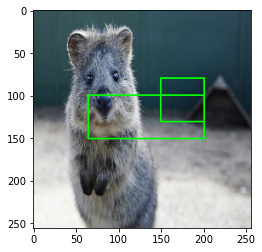

In [5]:
imgplot = plt.imshow(image_before)
plt.show()

Images loading,conversion and saving fucntions

In [6]:
import PIL
def loadImgToArray(url,info=False):
    """
    take the url and return the image (PIL format) as a numpy Array
    """
    image = PIL.Image.open(url)
    imgArray = np.asarray(image)
    if info:
        print(f'From: {type(image)}, Size: {image.size}, Mode: {image.mode}\nTo: {type(imgArray)}, shape: {imgArray.shape}')
    
    return imgArray

In [7]:
def saveArrayToImg(url,npArray,info=False):
    """
    Takes a numpy array and converts it 
    """
    image = PIL.Image.fromarray(npArray)
    if info:
        print(f'From: {type(npArray)}, shape: {npArray.shape}\nTo: {type(image)}, Size: {image.size}, Mode: {image.mode}')
    image.save(url)

In [9]:
# test
mainUrl = '/home/henri/Desktop/roboflow/quickTest/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'

npArray = loadImgToArray(mainUrl+'136.jpg', info=True)
saveArrayToImg(testUrl+'136.jpg', npArray,info=True)

From: <class 'PIL.JpegImagePlugin.JpegImageFile'>, Size: (1000, 1231), Mode: RGB
To: <class 'numpy.ndarray'>, shape: (1231, 1000, 3)
From: <class 'numpy.ndarray'>, shape: (1231, 1000, 3)
To: <class 'PIL.Image.Image'>, Size: (1000, 1231), Mode: RGB


BBox loading and saving functions

In [26]:
def convertImgaugBBToYolov3BB(args):
    # height, width, depth = img.shape
    # for i in args:
    #     print (i)
    oclass = int(args[0])
    x1 = float(args[1])
    y1 = float(args[2])
    x2 = float(args[3])
    y2 = float(args[4])

    x_pos = x1 / width + ((x2 - x1) / width /  2)
    y_pos = y1 / height + ((y2 - y1) / height / 2)
    x_size = (x2 - x1) / width
    y_size = (y2 - y1) / height

    return_args = [oclass, x_pos, y_pos, x_size, y_size]

    # Skip BBs that fall outside YOLOv3 range
    for r in return_args[1:]:
        if r > 1: return ()
        if r < 0: return()
    return (return_args)

In [10]:
from io import StringIO 
def loadingBBox(fileurl):
    """
    Assuming the data is in this format
    <object-class> <x> <y> <width> <height> 
    [1.      , 0.250126, 0.29366 , 0.471062, 0.410735]

    The boundary object
    """
    # take inspiration from this
    # https://github.com/dnissimi/imgaug-yolov3/blob/master/imgaug-yolov3.py
    # use the numpy array function
    # see you you can combine both (load and format) and (format then save)
    # see you if you can reform by keeping the labels since bbox allows for them
    # run and test until you get this right
    #  you can do this 

    boxData = np.loadtxt(fileurl)
    data = boxData[:,1:]
    label = boxData[:,0:1]
    return [label, data]

In [11]:
def saveBBox(fileurl, label, data):
    """
    save numpy array in this format
    1 0.250126 0.293660 0.471062 0.410735
    delimiter is a space 
    """
    fullAnnotation = np.column_stack([label,data])
    np.savetxt(fileurl, fullAnnotation,fmt='%f', delimiter=' ')

In [15]:
def imageBoxFit(data,npArray,operation):
    """
    type = ['load','save]
    since our yolo annotations comes in this format we need to resize to fit the image shape(x,y)
    x1=0.250126 y1=0.293660 x2=0.471062 y2=0.410735
    <object-class> <x> <y> <width> <height> 
    """
    if operation == 'load':
        data[:,0:3:2] = data[:,0:3:2]*npArray.shape[1] # x1,width columns
        data[:,1:4:2] = data[:,1:4:2]*npArray.shape[0] # y1,height columns
        # because imageaug doesn't accept x1,y1,w,h we have to do this shit manually
        data[:,-1::] = data[:,1:2:] + data[:,-1::] #y2
        data[:,-2::] = data[:,0:1:] + data[:,-2::] #x2

        
        return data
    # the exact bloody reverse
    if operation == 'save':
        data[:,0:3:2] = data[:,0:3:2]/npArray.shape[1] 
        data[:,1:4:2] = data[:,1:4:2]/npArray.shape[0]
        data[:,-1::] = data[:,1:2:] - data[:,-1::] #y2
        data[:,-2::] = data[:,0:1:] - data[:,-2::] #x2
        # data[:,-1::] = data[:,-1::] - data[:,1:2:] #y2
        # data[:,-2::] =  data[:,-2::] - data[:,0:1:]#x2 
        return data

In [16]:
# test (loading boxes)
mainUrl = '/home/henri/Desktop/roboflow/quickTest/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'
npArray = loadImgToArray(mainUrl+'2.jpg', info=True)
l,d = loadingBBox(mainUrl+'136.txt')
saveBBox(testUrl+'136.txt',l,d)
# test (confirming boxes width)

From: <class 'PIL.JpegImagePlugin.JpegImageFile'>, Size: (1000, 1627), Mode: RGB
To: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)


In [17]:
d

array([[0.508   , 0.753859, 0.888   , 0.141348],
       [0.5135  , 0.116572, 0.837   , 0.137287]])

In [18]:
d[:,0:1:] + d[:,-2::]

array([[1.396   , 0.649348],
       [1.3505  , 0.650787]])

In [19]:
d[:,-2::]

array([[0.888   , 0.141348],
       [0.837   , 0.137287]])

In [20]:
d[:,0:1:]

array([[0.508 ],
       [0.5135]])

Change to 

In [21]:
image = loadImgToArray(mainUrl+'2.jpg')
label,data = loadingBBox(mainUrl+'2.txt')
data = imageBoxFit(data,image,'load')
bbs = list()
for box in data:
    x1,y1,x2,y2 = box
    bbs.append(BoundingBox(x1, y1, x2, y2))
bbs = BoundingBoxesOnImage(bbs,shape=image.shape)

In [22]:
#setting the pipeline
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])
print(type(image),type(bbs))

<class 'numpy.ndarray'> <class 'imgaug.augmentables.bbs.BoundingBoxesOnImage'>


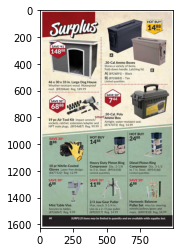

In [23]:
imgplot = plt.imshow(image)
plt.show()

In [24]:
# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, size=2)
image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

BB 0: (135.0000, 295.5006, 255.0000, 563.5014) -> (327.0117, 571.2321, 397.0353, 727.6184)
BB 1: (842.5000, 125.5003, 963.5000, 1101.0010) -> (739.8589, 472.0319, 810.4659, 1041.2654)
BB 2: (549.0000, 654.0003, 669.0000, 1337.0000) -> (568.5930, 780.4272, 638.6165, 1178.9777)
BB 3: (120.0000, 706.5003, 240.0000, 959.5011) -> (318.2588, 811.0626, 388.2823, 958.6959)
BB 4: (705.5000, 931.0003, 826.5000, 1770.5000) -> (659.9153, 942.0649, 730.5224, 1431.9377)
BB 5: (397.0000, 951.5005, 517.0000, 1481.5013) -> (479.8965, 954.0273, 549.9200, 1263.2985)
BB 6: (115.0000, 981.5008, 235.0000, 1229.5015) -> (315.3411, 971.5334, 385.3647, 1116.2491)
BB 7: (110.5000, 1289.0005, 229.5000, 1533.5002) -> (312.7152, 1150.9686, 382.1553, 1293.6414)
BB 8: (432.0000, 1279.5005, 552.0000, 1844.5012) -> (500.3200, 1145.4250, 570.3435, 1475.1196)
BB 9: (715.5000, 1292.0007, 836.5000, 2141.5004) -> (665.7506, 1152.7194, 736.3577, 1648.4275)
BB 10: (245.5000, 400.5007, 636.5000, 1049.0005) -> (391.4917, 632.5

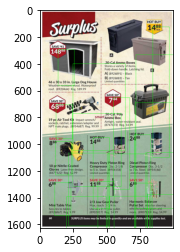

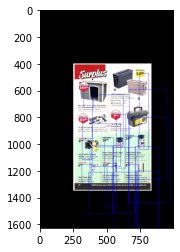

In [25]:
imgplot = plt.imshow(image_before)
plt.show()
imgplot = plt.imshow(image_after)
plt.show()

In [43]:
testUrl = '/home/henri/Desktop/roboflow/quickTest/'

saveArrayToImg(testUrl+'2test.jpg', image_aug,info=True) # def saveArrayToImg(url,npArray,info=False)
data = imageBoxFit(bbs_aug.to_xyxy_array,image_aug,'save') # def imageBoxFit(data,npArray,operation)
saveBBox(testUrl+'2test.txt',label,data) #saveBBox(fileurl, label, data)

From: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)
To: <class 'PIL.Image.Image'>, Size: (1000, 1627), Mode: RGB


TypeError: 'method' object is not subscriptable